In [ ]:
# BASELINE MODEL: FIGURE 2.3

# Lunar Leaper: Gravimetry Modelling
# Yara Luginbühl

# Input: Baseline.csv
# Output: GravitationalCorrections_final.png

In [ ]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics.gravimetry import GravityModelling2D, solveGravimetry
import matplotlib.pyplot as plt
from scipy.signal import detrend
import pandas as pd
from scipy.interpolate import interp1d


No module named 'trame'.
You need to install this optional dependency to use interactive 3D visualizations within Jupyter notebooks.


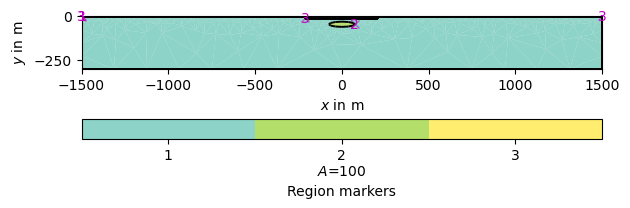

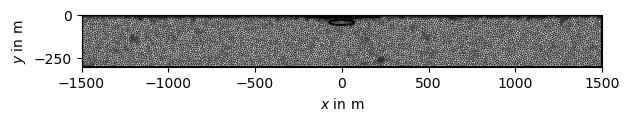

In [3]:
# DEF WORLD

regolith_thickness = 2

# Define rille variables:
x_top = 210
x_bottom = 210
y_top = 0  - regolith_thickness
y_middle = -5 - regolith_thickness
y_bottom = -10 - regolith_thickness

# World edges
xmax = 1500
ymin = -300

# lava tube
lava_tube_center_depth = 45
lava_tube_diameter = 150
lava_tube_height = 30


world = mt.createPolygon(
    [
        (-xmax, y_top),   
        (-x_top, y_top), 
        (-x_bottom, y_bottom),  
        (x_bottom, y_bottom),   

        (x_top, y_top),   
        (xmax, y_top),    
        (xmax, ymin),  
        (-xmax, ymin)  
    ],
    isClosed=True,
    addNodes=3,
    marker=1,
    boundaryMarker=1
)

cave = mt.createCircle(pos=[-0, -lava_tube_center_depth], 
                       radius=[lava_tube_diameter / 2, lava_tube_height / 2], marker=2,
                       boundaryMarker=10, area=100)


regolith_y_top = y_top + regolith_thickness
regolith_y_bottom = y_top 
regolith_rille_y_top = y_bottom + regolith_thickness
regolith_rille_y_bottom = y_bottom


# Create regolith polygon (covers full top area)
regolith_l = mt.createPolygon([
    (-xmax, regolith_y_top),
    (-x_top, regolith_y_top),
    (-x_top, regolith_y_bottom),
    (-xmax, regolith_y_bottom)
], isClosed=True, addNodes=3, marker=3)

regolith_r = mt.createPolygon([
    (xmax, regolith_y_top),
    (x_top, regolith_y_top),
    (x_top, regolith_y_bottom),
    (xmax, regolith_y_bottom)
], isClosed=True, addNodes=3, marker=3)

regolith_m = mt.createPolygon([
    (-x_top, regolith_rille_y_top),
    (x_top, regolith_rille_y_top),
    (x_top, regolith_rille_y_bottom),
    (-x_top, regolith_rille_y_bottom)
], isClosed=True, addNodes=3, marker=3)

y_rille = regolith_rille_y_top


regolith = regolith_l + regolith_r + regolith_m 

if (regolith_thickness == 0):
    geom = world + cave
else: 
    geom = world + cave + regolith


pg.show(geom)

mesh = mt.createMesh(geom, quality=33, area=100.)
pg.show(mesh)


# DEFINE DENSITIES
layer_densities = [[1, 2500], # region marker, density
                  [2, 0], 
                  [3, 1500]]

dRho = pg.solver.parseMapToCellArray(layer_densities, mesh) # map layer densities to mesh 



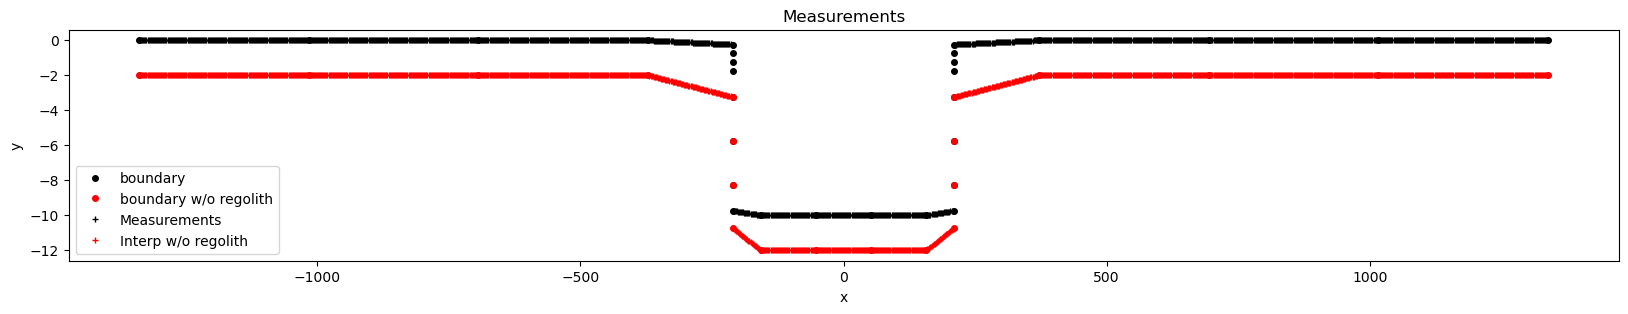

In [4]:
# DEF MEASUREMENTS (V2)

top_edges = []

for b in geom.boundaries():
    x = b.center()[0]
    y = b.center()[1]

    if (
        (abs(b.center()[0]) <= x_top and b.center()[1] >= y_rille)
        or
        (xmax > abs(b.center()[0]) > x_top) and (b.center()[1] >= regolith_y_top)
    ):
        top_edges.append((x,y))

top_edges = sorted(top_edges, key=lambda pt: (pt[0], pt[1] if pt[0] > 0 else -pt[1]))


# WITH REGOLITH
top_edges_x = [p[0] for p in top_edges]
top_edges_y = [p[1] for p in top_edges]


# Attention here: x has to be arranged correctly, +1 may cause issues depending on delta_s
delta_s = 2
points_x = np.arange(top_edges_x[0], top_edges_x[-1]+1, delta_s)
points_y = np.interp(points_x, top_edges_x, top_edges_y)
pnts = np.array([points_x, points_y]).T


world_edges = [
    (c.center()[0], c.center()[1]) for c in world.boundaries()
    if abs(c.center()[0]) < xmax and c.center()[1] >= y_bottom
]
world_edges_x = [p[0] for p in world_edges]
world_edges_y = [p[1] for p in world_edges]

world_x = np.arange(world_edges_x[0], world_edges_x[-1]+1, delta_s)
world_y = np.interp(world_x, world_edges_x, world_edges_y)
world_pnts = np.array([world_x, world_y])

plt.style.use('default')

plt.figure(figsize = (20,3))
plt.title("Measurements")
plt.plot(top_edges_x, top_edges_y, "ko", markersize = 4, label = "boundary")
plt.plot(world_edges_x, world_edges_y, "ro", markersize = 4, label = "boundary w/o regolith")
plt.plot(points_x, points_y, "k+", markersize = 4, label = "Measurements")
plt.plot(world_x, world_y, "r+", markersize = 4, label = "Interp w/o regolith")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
# plt.xlim(-230, -180)
plt.show()





In [5]:
fop = GravityModelling2D(mesh=mesh, points=pnts)
g_vector = solveGravimetry(fop.regionManager().paraDomain(), # output: gravity field measured at each measuring point (len(points))
                           dRho,
                           pnts=fop.sensorPositions,
                           complete=True)


C:\Users\yslug\AppData\Local\Temp\ipykernel_75876\3107125994.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  theta1 = np.arctan((x2-x)/(y2-y))
C:\Users\yslug\AppData\Local\Temp\ipykernel_75876\3107125994.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  theta2 = np.arctan((x1-x)/(y2-y))
C:\Users\yslug\AppData\Local\Temp\ipykernel_75876\3107125994.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  theta3 = np.arctan((x2-x)/(y1-y))
C:\Users\yslug\AppData\Local\Temp\ipykernel_75876\3107125994.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  theta4 = np.arctan((x1-x)/(y1-y))


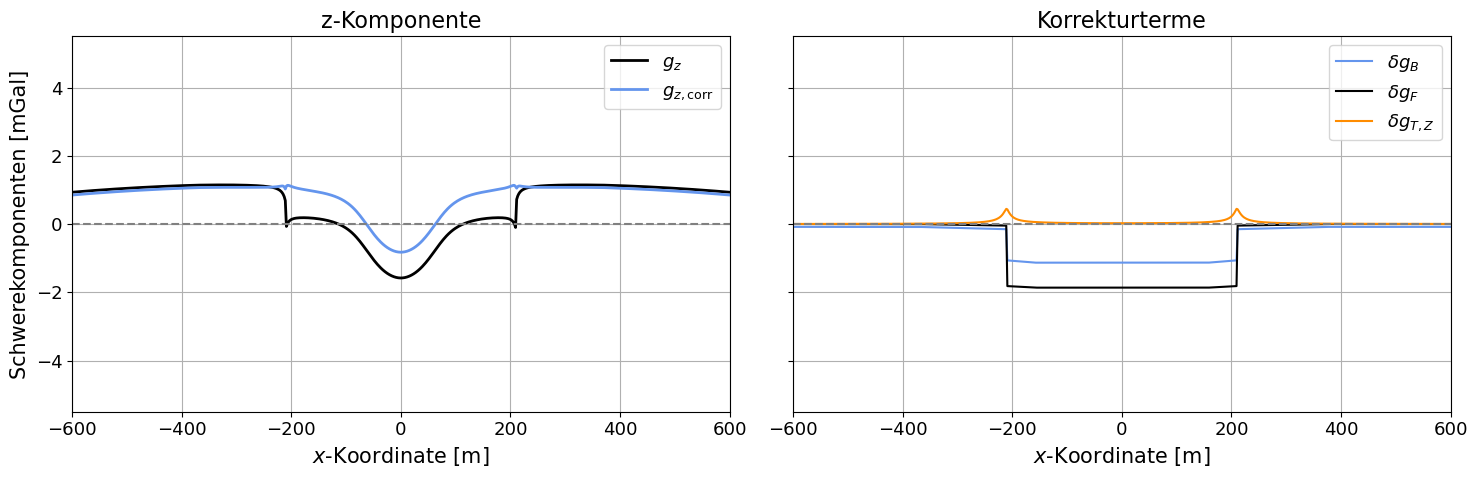

In [9]:
import scipy.integrate as spi

g = g_vector[0]
g_x = g[:,0]
g_z = g[:,2]


# Free air correction: 
g_mond = 1.62 #m/s^2
R_mond = 1738e3 #m
free_air_correction = ((2*g_mond/R_mond) * points_y)*1e5 #mGal

# Bouguer anomaly:
G = 6.6743e-11 #m3 kg-1 s-2
rho = 2500 # kg/m³
rho_regolith = 1500 # kg/m³
bouguer = rho*(2*np.pi*G*(world_y))*1e5 + rho_regolith*(2*np.pi*G*(points_y - world_y))*1e5 #mGal
bouguer2 = rho*(2*np.pi*G*points_y)*1e5



g_terrain = np.zeros(len(points_x))
distance = 2

g_pit = np.zeros(len(points_x))
g_regolith = np.zeros(len(points_x))


def g_korr(x1,x2,y1,y2,x,y, rho):
# python calcs arctan(-inf) = pi/2 automatically   
    theta1 = np.arctan((x2-x)/(y2-y))
    theta2 = np.arctan((x1-x)/(y2-y))
    theta3 = np.arctan((x2-x)/(y1-y))
    theta4 = np.arctan((x1-x)/(y1-y))
    
    return 2*G*rho*((y2-y)*(theta1 - theta2) - (y1-y)*(theta3 - theta4))*1e5



for i,x in enumerate(points_x):
    y = points_y[i] 

    #block 1 (x1,x2,y1,y2)
    x1_1 = -xmax
    x2_1 = -x_top
    y1_1 = regolith_rille_y_top
    y2_1 = y_top
    
    if (-x_top<= x <= x_top) or (x > x_top):
        g_terrain[i] += g_korr(x1_1, x2_1, y1_1, y2_1, x,y, rho)


    # block 1 regolith
    x1_regolith_l = -xmax
    x2_regolith_l = -x_top
    y1_regolith_l = y_top
    y2_regolith_l = regolith_y_top

    if (-x_top<= x <= x_top) or (x > x_top):
        g_regolith[i] += g_korr(x1_regolith_l, x2_regolith_l, y1_regolith_l, y2_regolith_l, x,y, rho_regolith)

   
    #block 2
    x1_2 = -x_top
    x2_2 = x_top
    y1_2 = regolith_rille_y_top
    y2_2 = y_top
    
    if (x < -x_top) or (x > x_top):
        g_terrain[i] -= g_korr(x1_2, x2_2, y1_2, y2_2, x, y, rho)
    
    # block 2 regolith
    x1_regolith_m = -x_top
    x2_regolith_m = x_top
    y1_regolith_m = y_top
    y2_regolith_m = regolith_y_top

    if (x < -x_top) or (x > x_top):
        g_regolith[i] -= g_korr(x1_regolith_m, x2_regolith_m, y1_regolith_m, y2_regolith_m, x, y, rho_regolith)
    

    #block 3
    x1_3 = x_top
    x2_3 = xmax
    y1_3 = regolith_rille_y_top
    y2_3 = y_top
    
    if (-x_top<= x <= x_top) or (x < x_top):
        g_terrain[i] += g_korr(x1_3, x2_3, y1_3, y2_3, x, y, rho)

    # block 3 regolith
    x1_regolith_r = x_top
    x2_regolith_r = xmax    
    y1_regolith_r = y_top
    y2_regolith_r = regolith_y_top

    if (-x_top<= x <= x_top) or (x < x_top):
        g_regolith[i] += g_korr(x1_regolith_r, x2_regolith_r, y1_regolith_r, y2_regolith_r, x, y, rho_regolith)




g_z_corr = g_z + bouguer - free_air_correction + g_terrain + g_regolith 





plt.style.use('default')
plt.rcParams.update({
    "font.size": 14,            # base font size
    "axes.titlesize": 16,       # title font
    "axes.labelsize": 15,       # axis labels
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

ax1.plot(points_x, g_z - np.mean(g_z), "-", linewidth=2, color = "black", label=r"$g_z$")
ax1.plot(points_x, g_z_corr - np.mean(g_z), "-", linewidth=2, color = "cornflowerblue", label=r"$g_{z,\mathrm{corr}}$")
ax1.axhline(0, color='gray', linestyle='--')

ax1.set_xlabel(r"$x$-Koordinate [m]")
ax1.set_ylabel("Schwerekomponenten [mGal]")
ax1.set_xlim((-600, 600))
ax1.set_ylim((-5.5, 5.5))
ax1.set_title("z-Komponente")
ax1.grid()
ax1.legend()


ax2.plot(points_x, bouguer, "-", color = "cornflowerblue", label=r"$\delta g_B$")
ax2.plot(points_x, free_air_correction, "-", color = "black" , label=r"$\delta g_F$")
ax2.plot(points_x, g_regolith + g_terrain, "-", color = "darkorange", label=r"$\delta g_{T,Z}$")
ax2.axhline(0, color='gray', linestyle='--')

ax2.set_xlabel(r"$x$-Koordinate [m]")
ax2.set_title("Korrekturterme")
ax2.set_xlim((-600, 600))
ax2.set_ylim((-5.5, 5.5))
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()






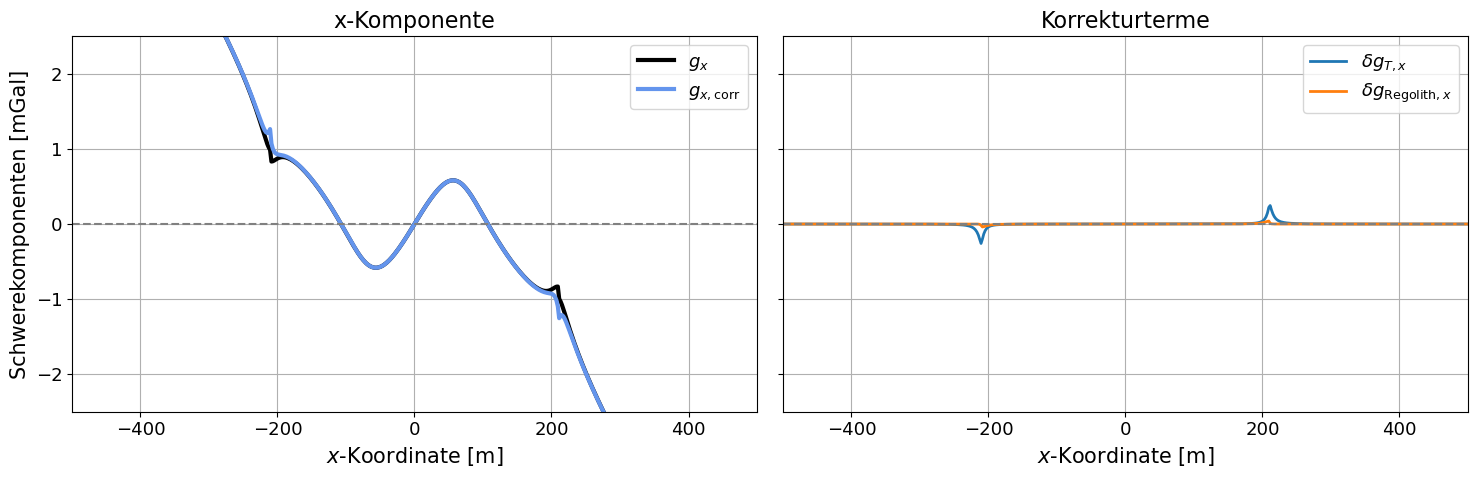

In [10]:
# HORIZONTAL COMPONENT (x-axis)
g_x = g[:, 0] 

def g_korr_x(x1,x2,y1,y2,x,y, rho):
# python calcs arctan(-inf) = pi/2 automatically   
    theta1 = np.arctan((y2-y)/(x2-x))
    theta2 = np.arctan((y1-y)/(x2-x))
    theta3 = np.arctan((y2-y)/(x1-x))
    theta4 = np.arctan((y1-y)/(x1-x))
    return 2*G*rho*((x2-x)*(theta1 - theta2) - (x1-x)*(theta3 - theta4))*1e5

g_terrain_x = np.zeros(len(points_x))
g_regolith_x = np.zeros(len(points_x))


for i,x in enumerate(points_x):
    y = points_y[i] 

    #block 1 (x1,x2,y1,y2)
    x1_1 = -xmax
    x2_1 = -x_top
    y1_1 = regolith_rille_y_top
    y2_1 = y_top
    
    if (-x_top<= x <= x_top) or (x > x_top):
        g_terrain_x[i] += g_korr_x(x1_1, x2_1, y1_1, y2_1, x,y, rho)


    # block 1 regolith
    x1_regolith_l = -xmax
    x2_regolith_l = -x_top
    y1_regolith_l = y_top
    y2_regolith_l = regolith_y_top

    if (-x_top<= x <= x_top):# or (x > x_top):
        g_regolith_x[i] += g_korr_x(x1_regolith_l, x2_regolith_l, y1_regolith_l, y2_regolith_l, x,y, rho_regolith)

   
    #block 2
    x1_2 = -x_top
    x2_2 = x_top
    y1_2 = regolith_rille_y_top
    y2_2 = y_top
    
    if (x < -x_top) or (x > x_top):
        g_terrain_x[i] -= g_korr_x(x1_2, x2_2, y1_2, y2_2, x, y, rho)
    
    # block 2 regolith
    x1_regolith_m = -x_top
    x2_regolith_m = x_top
    y1_regolith_m = y_top
    y2_regolith_m = regolith_y_top

    if (x < -x_top) or (x > x_top):
        g_regolith_x[i] -= g_korr_x(x1_regolith_m, x2_regolith_m, y1_regolith_m, y2_regolith_m, x, y, rho_regolith)
    

    #block 3
    x1_3 = x_top
    x2_3 = xmax
    y1_3 = regolith_rille_y_top
    y2_3 = y_top
    
    if (-x_top<= x <= x_top):#or (x < x_top):
        g_terrain_x[i] += g_korr_x(x1_3, x2_3, y1_3, y2_3, x, y, rho)

    # block 3 regolith
    x1_regolith_r = x_top
    x2_regolith_r = xmax    
    y1_regolith_r = y_top
    y2_regolith_r = regolith_y_top

    if (-x_top<= x <= x_top): #or (x < x_top):
        g_regolith_x[i] += g_korr_x(x1_regolith_r, x2_regolith_r, y1_regolith_r, y2_regolith_r, x, y, rho_regolith)


g_x_corr = g_x - g_terrain_x - g_regolith_x


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)


ax1.plot(points_x, g_x, "-", linewidth=3, color = "black", label=r"$g_x$")
ax1.plot(points_x, g_x_corr, "-", linewidth=3, color = "cornflowerblue", label=r"$g_{x,\mathrm{corr}}$")
ax1.axhline(0, color='gray', linestyle='--')

ax1.set_xlabel(r"$x$-Koordinate [m]")
ax1.set_ylabel("Schwerekomponenten [mGal]")
ax1.set_xlim((-500, 500))

ax1.set_title("x-Komponente")
ax1.grid()
ax1.legend()

ax2.plot(points_x, g_terrain_x, "-", linewidth=2, label=r"$\delta g_{T,x}$")
ax2.plot(points_x, g_regolith_x, "-", linewidth=2, label=r"$\delta g_{\mathrm{Regolith},x}$")
ax2.axhline(0, color='gray', linestyle='--')

ax2.set_xlabel(r"$x$-Koordinate [m]")
ax2.set_xlim((-500, 500))
ax1.set_ylim((-2.5, 2.5))
ax2.set_title("Korrekturterme")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()


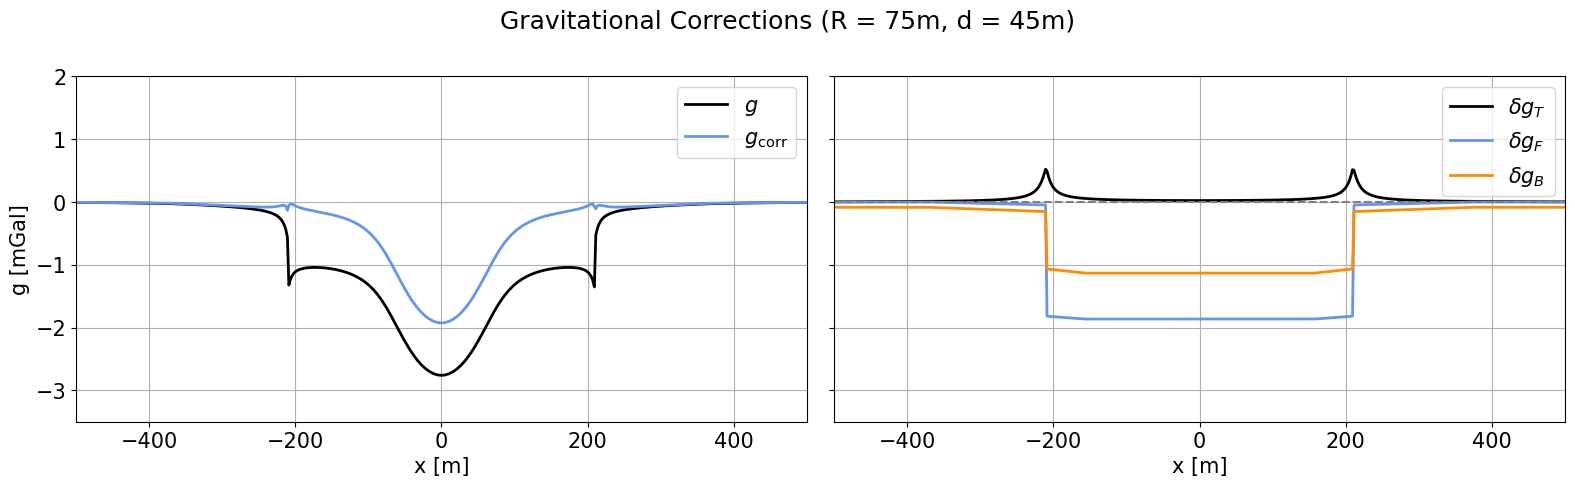

In [11]:

g_final = np.sqrt(g_x**2 + g_z**2)
g_corr = np.sqrt(g_x_corr**2 + g_z_corr**2)

df = pd.read_csv('Data/Baseline.csv')
mask = (df['x'] >= points_x.min()) & (df['x'] <= points_x.max())

xbaseline = df['x'].values[mask]
g = df['g'].values[mask]

f = interp1d(xbaseline,g, kind='linear', fill_value='extrapolate')
g_new = f(points_x)


# plt.savefig("fig2.png")
plt.rcParams.update({
    "font.size": 15,            # base font size
    "axes.titlesize": 16,       # title font
    "axes.labelsize": 15,       # axis labels
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
fig.suptitle("Gravitational Corrections (R = 75m, d = 45m)") 

detrend1 = g_final - g_new
detrend2 = g_corr - g_new 

ax1.plot(points_x, detrend1 - (detrend1[np.argmin(np.abs(points_x-600))] + detrend1[np.argmin(np.abs(points_x+600))])/2, "-", linewidth=2, color = "black", label=r"$g$")
ax1.plot(points_x, detrend2 - (detrend2[np.argmin(np.abs(points_x-600))] + detrend2[np.argmin(np.abs(points_x+600))])/2 , "-", linewidth=2, color = "cornflowerblue", label=r"$g_\mathrm{corr}$")


ax1.set_xlabel("x [m]")
ax1.set_ylabel("g [mGal]")
ax1.set_xlim((-500, 500))


ax1.grid()
ax1.legend()

ax2.plot(points_x, np.sqrt(g_terrain**2 + g_terrain_x**2) + np.sqrt(g_regolith**2 + g_regolith_x**2), "-", color = "black", linewidth=2, label=r"$\delta g_T$")
ax2.plot(points_x, free_air_correction, "-", color = "cornflowerblue", linewidth=2, label=r"$\delta g_F$")
ax2.plot(points_x, bouguer, "-", linewidth=2, color = "darkorange", label=r"$\delta g_B$")
ax2.axhline(0, color='gray', linestyle='--')

ax2.set_xlabel("x [m]")
ax2.set_xlim((-500, 500))
ax1.set_ylim((-3.5, 2))
# ax2.set_title("Korrekturterme")
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.savefig("Outputs/GravitationalCorrections.png")
plt.show()